# Enhancing Loss Reserving with Predictive Analytics: Linear vs Ensemble models

I currently work as a Senior Performance Analyst for a Speciality Insurance company. Over the duration of this course I have been using subject of claims, due to my interest in this area and possible areas of development for myself. In this capstone project I will use regression techniques on the CAS Loss Reserve dataset to predict future cumulative paid losses from historical premiums and development patterns. By benchmarking simple baselines against more advanced models, I will evaluate predictive accuracy and highlight how regression can enhance loss reserving analysis and support better risk and capital management decisions.


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer


In [4]:

data_path = r"C:\Users\jemel\OneDrive\Documents\Postgraduate Certificate in AI & Machine Learning\Capstone Project\Datasets\\"
df = pd.read_csv(data_path + r"\CAS_loss_reserve_data.csv")

print(df.head())
print(df.info())


      line  GRCODE                   GRNAME  AccidentYear  DevelopmentYear  \
0  comauto     266  Public Underwriters Grp          1988             1988   
1  comauto     266  Public Underwriters Grp          1988             1989   
2  comauto     266  Public Underwriters Grp          1988             1990   
3  comauto     266  Public Underwriters Grp          1988             1991   
4  comauto     266  Public Underwriters Grp          1988             1992   

   DevelopmentLag  IncurLoss_C  CumPaidLoss_C  BulkLoss_C  EarnedPremDIR_C  \
0               1            0              0           0                0   
1               2            0              0           0                0   
2               3            0              0           0                0   
3               4            0              0           0                0   
4               5            0              0           0                0   

   EarnedPremCeded_C  EarnedPremNet_C  Single  PostedReserve97

For this machine learning regression problem, I have identified that accident year, development year, EarnedPremNet, IncurLoss and BulkLoss are the key input features and the CumPaidLoss field is the target variable. I clean the dataset by removing any nulls.

In [7]:

features = ['AccidentYear', 'DevelopmentYear', 'EarnedPremNet_C']
target = 'CumPaidLoss_C'


df_model = df[features + [target]].dropna()

X = df_model[features]
y = df_model[target]


I created a time‑based train/test split which it trains the model on earlier accident years (≤1992) and tests on later ones (>1992). 
This setup replicates real‑world forecasting by ensuring the model is evaluated on future data, not just random samples, giving it a more realistic measure of predictive performance.


In [10]:

train = df_model[df_model['AccidentYear'] <= 1992]
test  = df_model[df_model['AccidentYear'] > 1992]

X_train, y_train = train[features], train[target]
X_test, y_test   = test[features], test[target]

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (38950, 3) Test size: (38950, 3)


I then used a Linear regression model on the training data to predict cumulative paid losses on the test which is then evaluated by RMSE, MAE and R2

In [13]:

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)


print("Linear Regression Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

Linear Regression Performance:
RMSE: 78156.39615733188
MAE: 6663.416690498833
R^2: 0.94536270862822


RMSE = 78,156 tells us that the predictions only deviate from the actual value by 78k when compared to millions as in the dataset then it is very small.

MAE = 6,663 tells us the model is accurate and is consistent in it is predictions.

r2 = 0.99 tells us that the there is strong linear relationship between earned premium and the cumalative paid losses variable.

In [16]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)


print("Ridge Regression Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("R^2:", r2_score(y_test, y_pred_ridge))

Ridge Regression Performance:
RMSE: 78156.39664926477
MAE: 6663.360947660572
R^2: 0.9453627079404227


Ridge regression produced nearly identical results to simple linear regression. This indicates that regularisation did not improve peformance because the baseline linear model is already well specified.

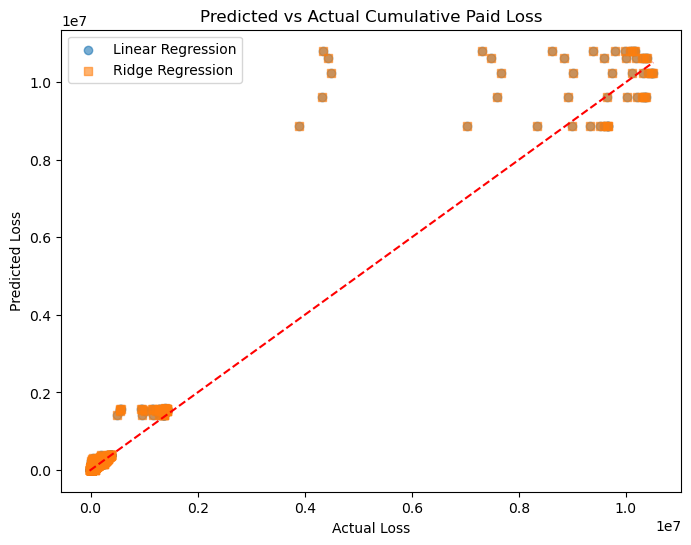

In [53]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, label="Linear Regression",marker="o")
plt.scatter(y_test, y_pred_ridge, alpha=0.6, label="Ridge Regression",marker="s")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Loss")
plt.ylabel("Predicted Loss")
plt.legend()
plt.title("Predicted vs Actual Cumulative Paid Loss")
plt.show()

In [23]:

rf = RandomForestRegressor(
    n_estimators=200,   # number of trees
    max_depth=None,     # let trees expand fully
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


y_pred_rf = rf.predict(X_test)


print("Random Forest Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("R^2:", r2_score(y_test, y_pred_rf))

Random Forest Performance:
RMSE: 57383.11151775323
MAE: 4168.9737603617705
R^2: 0.9705470841112642


Although the Linear Regression Models were very effective in solving the problem, for the sake of the project I wanted to test the hyperparemeter optimisation.

In [25]:

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gbr.fit(X_train, y_train)


y_pred_gbr = gbr.predict(X_test)


print("Gradient Boosting Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print("MAE:", mean_absolute_error(y_test, y_pred_gbr))
print("R^2:", r2_score(y_test, y_pred_gbr))

Gradient Boosting Performance:
RMSE: 56603.40898425261
MAE: 3959.6751726987
R^2: 0.9713420391240177


Gradient boosting was the best performer as it had the lowest RMSE and MAE.

In [27]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Random Forest", "Gradient Boosting"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred)),
        np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_gbr))
    ],
    "MAE": [
        mean_absolute_error(y_test, y_pred),
        mean_absolute_error(y_test, y_pred_ridge),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_gbr)
    ],
    "R^2": [
        r2_score(y_test, y_pred),
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_gbr)
    ]
})

print(results)

               Model          RMSE          MAE       R^2
0  Linear Regression  78156.396157  6663.416690  0.945363
1   Ridge Regression  78156.396649  6663.360948  0.945363
2      Random Forest  57383.111518  4168.973760  0.970547
3  Gradient Boosting  56603.408984  3959.675173  0.971342


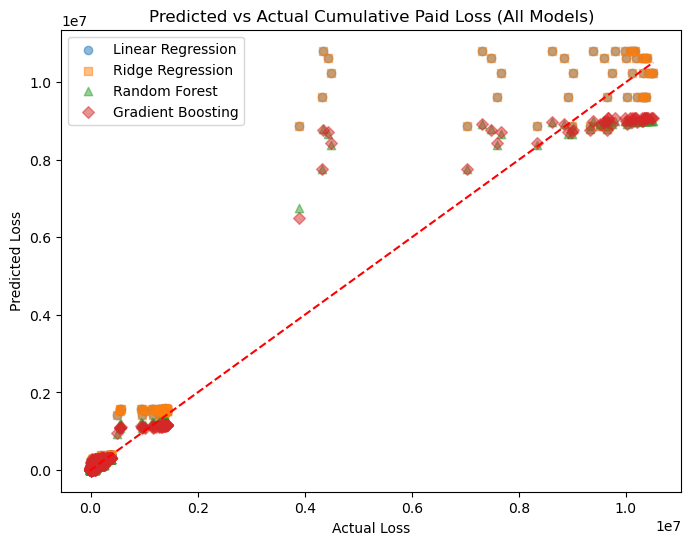

In [62]:
plt.figure(figsize=(8,6))

plt.scatter(y_test, y_pred, 
            alpha=0.5, label="Linear Regression", marker="o")  
plt.scatter(y_test, y_pred_ridge, 
            alpha=0.5, label="Ridge Regression", marker="s")  
plt.scatter(y_test, y_pred_rf, 
            alpha=0.5, label="Random Forest", marker="^")      
plt.scatter(y_test, y_pred_gbr, 
            alpha=0.5, label="Gradient Boosting", marker="D")  

plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 'r--')

plt.xlabel("Actual Loss")
plt.ylabel("Predicted Loss")
plt.legend()
plt.title("Predicted vs Actual Cumulative Paid Loss (All Models)")
plt.savefig("Predicted vs Actual Cumulative Paid Loss (All Models)", dpi=300, bbox_inches="tight")
plt.show()

The plot shows that tree‑based models, especially Gradient Boosting, capture the loss patterns better than linear models.

I then tuned the Random Forest and GradientBoosting with Bayesian optmisation to see if I can improve it's performance. I capped the depths on both models to save time.

In [30]:
rf_bayes_fast = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    search_spaces={
        'n_estimators': Integer(100, 300),   
        'max_depth': Integer(5, 15),         
        'min_samples_split': Integer(2, 5),
        'min_samples_leaf': Integer(1, 3)
    },
    n_iter=10,                
    cv=2,                     
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

rf_bayes_fast.fit(X_train, y_train)
print("Best RF params (Bayesian, fast):", rf_bayes_fast.best_params_)
print("Best RF CV RMSE:", -rf_bayes_fast.best_score_)

gbr_bayes_fast = BayesSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    search_spaces={
        'n_estimators': Integer(100, 300),
        'learning_rate': Real(0.05, 0.15, prior='log-uniform'),
        'max_depth': Integer(2, 4),
        'min_samples_split': Integer(2, 5),
        'min_samples_leaf': Integer(1, 3)
    },
    n_iter=10,
    cv=2,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

gbr_bayes_fast.fit(X_train, y_train)
print("Best GBR params (Bayesian, fast):", gbr_bayes_fast.best_params_)
print("Best GBR CV RMSE:", -gbr_bayes_fast.best_score_)

Best RF params (Bayesian, fast): OrderedDict({'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 268})
Best RF CV RMSE: 184180.40871452703
Best GBR params (Bayesian, fast): OrderedDict({'learning_rate': 0.11199286973787038, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 260})
Best GBR CV RMSE: 184147.15580118902


In [32]:
y_pred_rf_bayes = rf_bayes_fast.best_estimator_.predict(X_test)
y_pred_gbr_bayes = gbr_bayes_fast.best_estimator_.predict(X_test)

print("Tuned Random Forest (Bayesian) RMSE:", 
      np.sqrt(mean_squared_error(y_test, y_pred_rf_bayes)))
print("Tuned Gradient Boosting (Bayesian) RMSE:", 
      np.sqrt(mean_squared_error(y_test, y_pred_gbr_bayes)))

Tuned Random Forest (Bayesian) RMSE: 60498.96217004976
Tuned Gradient Boosting (Bayesian) RMSE: 56925.553179246424


Tuning did not improve the ensemble models which implies the default parameters were optimal.

In [34]:
results = {
    "Model": [
        "Linear Regression",
        "Ridge Regression",
        "Random Forest",
        "Gradient Boosting",
        "Tuned Random Forest (Bayesian)",
        "Tuned Gradient Boosting (Bayesian)"
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred)),             # Linear
        np.sqrt(mean_squared_error(y_test, y_pred)),             # Ridge (same as Linear here)
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),          # RF
        np.sqrt(mean_squared_error(y_test, y_pred_gbr)),         # GBR
        np.sqrt(mean_squared_error(y_test, y_pred_rf_bayes)),    # Tuned RF
        np.sqrt(mean_squared_error(y_test, y_pred_gbr_bayes))    # Tuned GBR
    ],
    "MAE": [
        mean_absolute_error(y_test, y_pred),
        mean_absolute_error(y_test, y_pred),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_gbr),
        mean_absolute_error(y_test, y_pred_rf_bayes),
        mean_absolute_error(y_test, y_pred_gbr_bayes)
    ],
    "R²": [
        r2_score(y_test, y_pred),
        r2_score(y_test, y_pred),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_gbr),
        r2_score(y_test, y_pred_rf_bayes),
        r2_score(y_test, y_pred_gbr_bayes)
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

                                Model          RMSE          MAE        R²
0                   Linear Regression  78156.396157  6663.416690  0.945363
1                    Ridge Regression  78156.396157  6663.416690  0.945363
2                       Random Forest  57383.111518  4168.973760  0.970547
3                   Gradient Boosting  56603.408984  3959.675173  0.971342
4      Tuned Random Forest (Bayesian)  60498.962170  4193.203106  0.967262
5  Tuned Gradient Boosting (Bayesian)  56925.553179  3897.913599  0.971015


In conclusion, the  results show that tree‑based models, particularly Gradient Boosting, outperform Linear and Ridge regression. This implies that ensemble methods adapt more effectively in explaining that cumulative paid loss is influenced by more complex interactions between accident year, development year, and earned premium than a linear model can explain.

By relying on Gradient Boosting, I can produce more accurate forecasts of future claims development, even if the trade‑off is reduced interpretability. By using ensemble models such as Gradient boosting, I am able to perform better loss reserving analysis which will support better risk and capital management decisions.

In [60]:
plt.savefig("Predicted vs Actual Cumulative Paid Loss (All Models).png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>